In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC

from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import matplotlib.pyplot as plt

In [2]:
# Read embeddings
data = pd.read_csv("../2.Feature extraction/embeddings/Azure_text-similarity-ada-002_embeddings.csv", index_col=0)

#### FEATURE ENGINEERING ####
# Suffix column
def get_suffix_from_intent(intent: str) -> str:
    return intent.split("-")[-1].strip()
data["suffix"] = data.intent.apply(lambda x: get_suffix_from_intent(x))

# Choose embeddings to use
embedding_to_use = "embedding_cleaned_asr"
embeddings = ["embedding_asr","embedding_cleaned_asr","embedding_cleaned_asr_without_stopw"]
embeddings.remove(embedding_to_use)
data = data.drop(columns=embeddings, axis = 1)

# Create feature x embedding dimension
data["embedding"] = data[embedding_to_use].apply(eval).apply(np.array)
tags = data['embedding'].apply(pd.Series)
features = tags.rename(columns = lambda x : 'embedding_feature_' + str(x))
result = pd.concat([data, features], axis=1)
df = result.drop(columns=["embedding"], axis=1)

# Create sets
X = df.drop(columns=["label"], axis = 1)
y = df["label"]

# Encode label
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [5]:
#### VALIDATE MODEL #### 

svm_results = pd.DataFrame()
parameters_column = []
score_column = []
accuracy_test_column = []
recall_test_column = []
precision_test_column = []
f1_test_column = []

accuracy_train_column = []
recall_train_column = []
precision_train_column = []
f1_train_column = []


for i in range(10):
    print(f"Iteration {i}.")
    # Divide data in training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1)

    # Feature engineering
    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)
    numerical_columns = numerical_columns_selector(X_train)
    categorical_columns = categorical_columns_selector(X_train)
    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()
    preprocessor = ColumnTransformer(
        [
            ("one-hot-encoder", categorical_preprocessor, categorical_columns),
            ("standard_scaler", numerical_preprocessor, numerical_columns),
        ]
    )

    # Train data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_train_preprocessed = pd.DataFrame(data=X_train_preprocessed, columns=preprocessor.get_feature_names_out())
    # Test data
    X_test_preprocessed = preprocessor.transform(X_test)
    X_test_preprocessed = pd.DataFrame(data=X_test_preprocessed, columns=preprocessor.get_feature_names_out())

    # Validate parameters
    model = SVC()

    parameters = {
                    'kernel':('linear', 'rbf'), 
                    'C': [0.1, 1, 10, 100, 1000], 
                    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
                }

    clf = GridSearchCV(model,parameters,cv = 10, n_jobs = -1)
    clf.fit(X_train_preprocessed, y_train)

    # Best parameters
    best_parameters = clf.best_params_ 
    best_score = clf.best_score_ 
    best_estimator = clf.best_estimator_

    parameters_column.append(best_parameters)
    score_column.append(best_score)
    print(f"Best score: {best_score}")

    # Prediction
    y_pred_test = best_estimator.predict(X_test_preprocessed)
    accuracy_test = accuracy_score(y_test,y_pred_test)
    precision_test = precision_score(y_test,y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    f1_test = f1_score(y_test,y_pred_test)

    y_pred_train = best_estimator.predict(X_train_preprocessed)
    accuracy_train = accuracy_score(y_train,y_pred_train)
    precision_train = precision_score(y_train,y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    f1_train = f1_score(y_train,y_pred_train)

    accuracy_test_column.append(accuracy_test)
    precision_test_column.append(precision_test)
    recall_test_column.append(recall_test)
    f1_test_column.append(f1_test)

    accuracy_train_column.append(accuracy_train)
    precision_train_column.append(precision_train)
    recall_train_column.append(recall_train)
    f1_train_column.append(f1_train)



svm_results["best_score"] = score_column
svm_results["best_parameters"] = parameters_column
svm_results["test_accuracy"] = accuracy_test_column
svm_results["test_precision"] = precision_test_column
svm_results["test_recall"] = recall_test_column
svm_results["test_f1"] = f1_test_column
svm_results["train_accuracy"] = accuracy_train_column
svm_results["train_precision"] = precision_train_column
svm_results["train_recall"] = recall_train_column
svm_results["train_f1"] = f1_train_column

Iteration 0.
Best score: 0.8228916809442224
Iteration 1.
Best score: 0.8238720731010851
Iteration 2.
Best score: 0.826908433276223
Iteration 3.
Best score: 0.8228250523510374
Iteration 4.
Best score: 0.8220350276032743
Iteration 5.
Best score: 0.8297544260422616
Iteration 6.
Best score: 0.8296973158195318
Iteration 7.
Best score: 0.8142299638301923
Iteration 8.
Best score: 0.8219969541214545
Iteration 9.
Best score: 0.8220255092328193


In [6]:
svm_results.to_csv('SVM_validate_results_model_14.csv')

### 2.Validation results

#### Experiment 14: OpenAI embeddings with Davinci model and preprocessed text with stopwords

In [4]:
svm_results = pd.read_csv("validation_results/SVM_validate_results_model_14.csv", index_col=0)
svm_results.head()

,best_score,best_parameters,test_accuracy,test_precision,test_recall,test_f1,train_accuracy,train_precision,train_recall,train_f1
0,0.822892,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.791304,0.719298,0.836735,0.773585,1.00000,1.000000,1.000000,1.000000
1,0.823872,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.800000,0.774194,0.842105,0.806723,1.00000,1.000000,1.000000,1.000000
2,0.826908,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.773913,0.781250,0.806452,0.793651,1.00000,1.000000,1.000000,1.000000
3,0.822825,"{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}",0.791304,0.761194,0.864407,0.809524,0.97179,0.963964,0.983456,0.973612
4,0.822035,"{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}",0.817391,0.783333,0.854545,0.817391,1.00000,1.000000,1.000000,1.000000


In [5]:
# Metrics
print(f"Mean test accuracy: {round(svm_results.test_accuracy.mean(),3)} +- {round(svm_results.test_accuracy.std(),3)}")
print(f"Mean train accuracy: {round(svm_results.train_accuracy.mean(),3)} +- {round(svm_results.train_accuracy.std(),3)}")
print(f"Mean test precision: {round(svm_results.test_precision.mean(),3)} +- {round(svm_results.test_precision.std(),3)}")
print(f"Mean train precision: {round(svm_results.train_precision.mean(),3)} +- {round(svm_results.train_precision.std(),3)}")
print(f"Mean test recall: {round(svm_results.test_recall.mean(),3)} +- {round(svm_results.test_recall.std(),3)}")
print(f"Mean train recall: {round(svm_results.train_recall.mean(),3)} +- {round(svm_results.train_recall.std(),3)}")
print(f"Mean test f1 score: {round(svm_results.test_f1.mean(),3)} +- {round(svm_results.test_f1.std(),3)}")
print(f"Mean train f1 score: {round(svm_results.train_f1.mean(),3)} +- {round(svm_results.train_f1.std(),3)}")

Mean test accuracy: 0.799 +- 0.02
Mean train accuracy: 0.997 +- 0.009
Mean test precision: 0.79 +- 0.037
Mean train precision: 0.996 +- 0.011
Mean test recall: 0.836 +- 0.029
Mean train recall: 0.998 +- 0.005
Mean test f1 score: 0.812 +- 0.021
Mean train f1 score: 0.997 +- 0.008


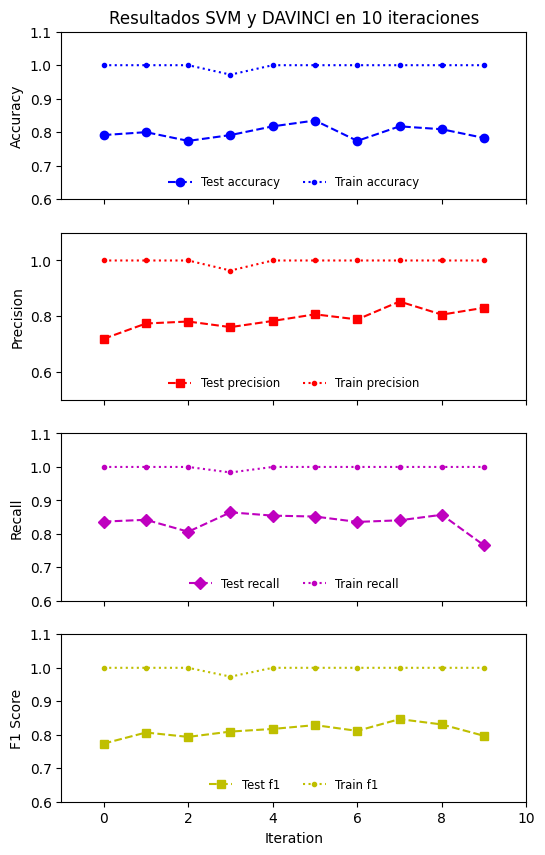

In [9]:
# Figures
acc_test = svm_results.test_accuracy
precision_test = svm_results.test_precision
recall_test = svm_results.test_recall
f1_test = svm_results.test_f1
acc_train = svm_results.train_accuracy
precision_train = svm_results.train_precision
recall_train = svm_results.train_recall
f1_train = svm_results.train_f1

x = np.array(range(0, 10))

fig,ax = plt.subplots(4,1, sharex=True,figsize=[6, 10])


ax[0].plot(x, acc_test, marker='o', color='b', linestyle='--', label='Test accuracy')
ax[0].plot(x, acc_train, marker='.', color='b', linestyle='dotted', label='Train accuracy')
ax[1].plot(x, precision_test, marker='s', color='r', linestyle='--', label='Test precision')
ax[1].plot(x, precision_train, marker='.', color='r', linestyle='dotted', label='Train precision')

ax[2].plot(x, recall_test,marker='D', color='m', linestyle='--', label='Test recall')
ax[2].plot(x, recall_train, marker='.', color='m', linestyle='dotted', label='Train recall')

ax[3].plot(x, f1_test, marker='s', color='y', linestyle='--', label='Test f1')
ax[3].plot(x, f1_train, marker='.', color='y', linestyle='dotted', label='Train f1')

ax[3].set_xlabel('Iteration')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlim(-1,10)
ax[0].set_ylim(0.6,1.1)
ax[1].set_ylabel('Precision')
ax[1].set_ylim(0.5,1.1)
ax[2].set_ylabel('Recall')
ax[2].set_ylim(0.6,1.1)
ax[3].set_ylabel('F1 Score')
ax[3].set_ylim(0.6,1.1)
ax[0].set_title('Resultados SVM y DAVINCI en 10 iteraciones')

ax[0].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[1].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[2].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')
ax[3].legend(loc='lower center', frameon=False,ncol=2,fontsize ='small')

plt.show()